# 0.0 Imports

In [227]:

import seaborn as sns
import numpy as np
import lightgbm as lgbm
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import HTML
from sklearn.model_selection import cross_val_predict, cross_validate, StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.impute import KNNImputer
from math import ceil
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from collections import Counter

## 0.1 Helper Functions

In [98]:
def jupyter_settings():
    %matplotlib inline

    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 20

    display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)

    color_pal = sns.color_palette()
    plt.style.use('fivethirtyeight')

    # configura o pandas para quantidade de casas decimais
    pd.options.display.float_format = '{:,.2f}'.format

    sns.set()
jupyter_settings()    
    

seed=7
number_folds = 4
Kfold = StratifiedKFold(n_splits=number_folds, shuffle=True, random_state=seed)

def nan_transformer(data): 
    '''
    Os valores limiares foram escolhidos baseado nos valores observador no Q3 e usando bom senso, valores absurdos foram considerados Nan
    '''
    data['idade'] = data['idade'].apply(lambda x: np.nan if x > 100 else x)
    data['num_emprestimos'] = data['num_emprestimos'].apply(lambda x: np.nan if x > 15 else x)
    data['num_contas_bancarias'] = data['num_contas_bancarias'].apply(lambda x: np.nan if x > 15 else x)
    data['num_cartoes_credito'] = data['num_cartoes_credito'].apply(lambda x: np.nan if x > 15 else x)
    data['num_pgtos_atrasados'] = data['num_pgtos_atrasados'].apply(lambda x: np.nan if x > 30 else x)
    data['num_consultas_credito'] = data['num_consultas_credito'].apply(lambda x: np.nan if x > 30 else x)
    data['taxa_juros'] = data['taxa_juros'].apply(lambda x: np.nan if x > 50 else x)


def round_col(data): 
    
    data['idade'] = data['idade'].apply(lambda x: ceil(x)) 
    data['num_emprestimos'] = data['num_emprestimos'].apply(lambda x: ceil(x)) 
    data['num_contas_bancarias'] = data['num_contas_bancarias'].apply(lambda x: ceil(x))
    data['num_cartoes_credito'] = data['num_cartoes_credito'].apply(lambda x: ceil(x))
    data['num_pgtos_atrasados'] = data['num_pgtos_atrasados'].apply(lambda x: ceil(x))
    data['num_consultas_credito'] = data['num_consultas_credito'].apply(lambda x: ceil(x))
    data['taxa_juros'] = data['taxa_juros'].apply(lambda x: ceil(x)) 

def apply_log(data):
    drop_features =['id_cliente', 'dias_atraso_dt_venc']
    
    numerical =  data.select_dtypes(include=["number","int64"]).drop(drop_features, axis=1)
    numerical_features = numerical.columns
    log_columns = data[numerical_features].skew().sort_values(ascending=False)
    log_columns = log_columns.loc[log_columns > 0.75]
    for col in log_columns.index:
         data[col] = np.log1p(data[col])
    

def CM(y, y_pred):
    print("Confusion Matrix:")
    labels = ['Negar', 'Conceder']
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="binary", values_format="d")  
    plt.show() 
    print("Metrics \n", classification_report(y,y_pred))

def CVS(model, X, y):
    
  
    scoring = {#'Accuracy': make_scorer(accuracy_score),
               #'Precision': make_scorer(precision_score),
               'f1': make_scorer(f1_score, average='weighted')}
               #'Recall': make_scorer(recall_score)}
    
    
    y_pred = cross_val_predict(model, X, y, cv=number_folds)
    print("\n")      
    CM(y, y_pred) 

    print("\n") 
   
    scores = cross_validate(model, X, y, cv = Kfold, scoring=scoring )
    
    for chave, valor in scores.items():
        print(f"{chave}\n{valor} Mean: {valor.mean()} +/- {valor.std()}")      


## 0.2 Loading Data

In [100]:
data_train_raw = pd.read_csv('train.csv')
data_test_raw = pd.read_csv('test.csv')

In [101]:
data = data_train_raw.copy()

In [102]:
data.head()

,id_cliente,idade,saldo_atual,divida_atual,renda_anual,valor_em_investimentos,taxa_utilizacao_credito,num_emprestimos,num_contas_bancarias,num_cartoes_credito,dias_atraso_dt_venc,num_pgtos_atrasados,num_consultas_credito,taxa_juros,investe_exterior,pessoa_polit_exp,limite_adicional
0,1767,21,278.17,"2,577.05","24,196.90",104.31,31.04,6,5,7,21,14,9,15,Não,Não,Negar
1,11920,40,268.87,"2,465.39","19,227.38",69.86,36.92,5,8,5,40,23,10,18,Não,Não,Negar
2,8910,36,446.64,"1,055.29","42,822.28",134.20,34.56,0,3,6,26,13,3,15,Sim,Não,Negar
3,4964,58,321.14,703.05,"51,786.83",297.35,31.49,0,3,7,12,7,2,1,Sim,Não,Negar
4,10100,35,428.72,891.29,"44,626.85",134.20,28.03,2,8,7,24,10,8,20,Sim,Não,Negar


# 1.0 Data Description

## 1.1 Data Dimensions

In [104]:
print( 'Number of Rows: {}'.format( data.shape[0] ) )
print( 'Number of Columns: {}'.format( data.shape[1] ) )

Number of Rows: 9500
Number of Columns: 17


## 1.2 Data Types

In [105]:
data.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc          int64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior            object
pessoa_polit_exp            object
limite_adicional            object
dtype: object

## 1.3 Check NA

In [106]:
data.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
limite_adicional           0
dtype: int64

## 1.4 Check balance data

In [107]:
data['limite_adicional'].value_counts(), data['limite_adicional'].value_counts(normalize=True)

(Negar       7995
 Conceder    1505
 Name: limite_adicional, dtype: int64,
 Negar      0.84
 Conceder   0.16
 Name: limite_adicional, dtype: float64)

# 2.0 EDA

## 2.1 Descriptive statistics

In [270]:
df1 = data.copy()

In [271]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

### 2.1.1 Numerical attributes

In [272]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
id_cliente,"9,500.00","6,210.53","3,603.24",1.00,"3,091.75","6,172.50","9,320.25","12,500.00"
idade,"9,500.00",126.40,685.04,18.00,28.00,38.00,47.00,"8,598.00"
saldo_atual,"9,500.00",404.53,217.70,0.09,272.36,337.17,471.26,"1,602.04"
divida_atual,"9,500.00","1,437.09","1,156.26",0.23,573.62,"1,175.73","1,963.33","4,998.07"
renda_anual,"9,500.00","195,037.27","1,454,273.73","10,473.87","26,207.90","45,991.11","80,449.83","23,279,657.98"
valor_em_investimentos,"9,500.00",612.00,"2,002.44",0.00,76.08,134.20,249.18,"10,000.00"
taxa_utilizacao_credito,"9,500.00",32.27,5.11,20.99,28.08,32.26,36.46,49.56
num_emprestimos,"9,500.00",10.86,62.56,0.00,2.00,3.00,6.00,"1,496.00"
num_contas_bancarias,"9,500.00",17.55,120.98,0.00,3.00,6.00,7.00,"1,779.00"
num_cartoes_credito,"9,500.00",21.43,122.68,1.00,4.00,6.00,7.00,"1,479.00"


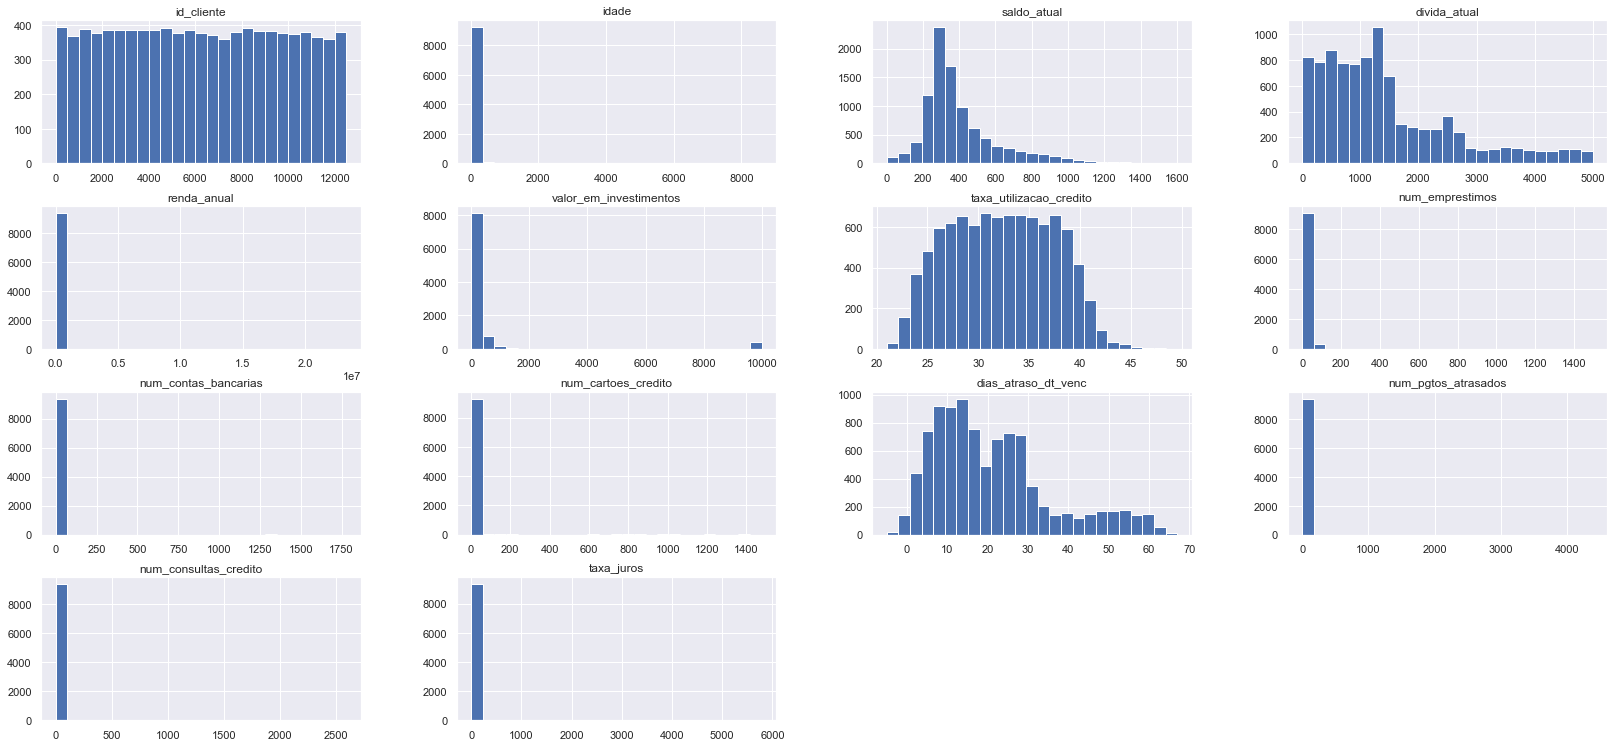

In [273]:
num_attributes.hist(bins=25);

### 2.1.2 Correlation Heatmap

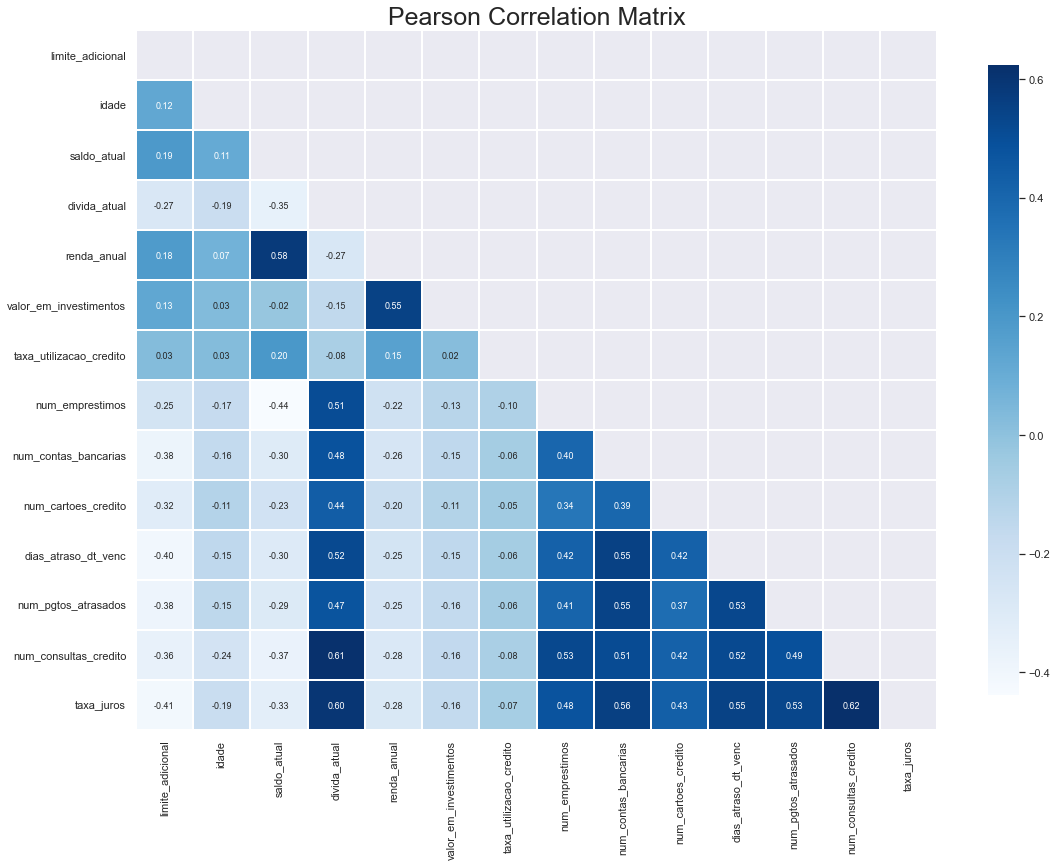

In [274]:
df1['limite_adicional'] = df1['limite_adicional'].apply(lambda x: 0 if x =='Negar' else 1)

correlation = ['limite_adicional']
numerical_features = df1.select_dtypes(include = ['int64','float64']).drop(["id_cliente", "limite_adicional"], axis=1).columns.values                              
correlation.extend(numerical_features)

mask = np.zeros_like(df1[correlation].corr(), dtype=bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))

plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df1[correlation].corr(method='spearman'), linewidths=0.25,fmt=".2f", cmap="Blues", linecolor='w',annot=True,annot_kws={"size":9},mask=mask,cbar_kws={"shrink": .9});

In [275]:
df1[correlation].corr()['limite_adicional'].abs().sort_values(ascending = False)

limite_adicional          1.00
dias_atraso_dt_venc       0.35
divida_atual              0.26
saldo_atual               0.19
taxa_utilizacao_credito   0.03
num_emprestimos           0.03
num_pgtos_atrasados       0.02
idade                     0.02
valor_em_investimentos    0.01
renda_anual               0.01
num_contas_bancarias      0.01
num_cartoes_credito       0.00
num_consultas_credito     0.00
taxa_juros                0.00
Name: limite_adicional, dtype: float64

### 2.1.2 Categorical attributes

In [276]:
cat_attributes.apply(lambda x: x.unique().shape[0])

investe_exterior    2
pessoa_polit_exp    2
limite_adicional    2
dtype: int64

# 3.0 Feature Engineering

In [108]:
df2 = data.copy()

## 3.1 Data Inputation - KNN

In [109]:
nan_transformer(df2)

In [110]:
df2.isna().sum()

id_cliente                   0
idade                      280
saldo_atual                  0
divida_atual                 0
renda_anual                  0
valor_em_investimentos       0
taxa_utilizacao_credito      0
num_emprestimos            406
num_contas_bancarias       125
num_cartoes_credito        212
dias_atraso_dt_venc          0
num_pgtos_atrasados         66
num_consultas_credito      150
taxa_juros                 175
investe_exterior             0
pessoa_polit_exp             0
limite_adicional             0
dtype: int64

In [111]:
y_knn = df2['limite_adicional']
X_knn = df2.drop(['id_cliente','limite_adicional'], axis=1)
numerical_features = X_knn.select_dtypes(include = ['int64','float64']).columns.values
categorical_features = X_knn.select_dtypes(include = ['object']).columns.values
num_impute = KNNImputer()
num_impute.fit(X_knn[numerical_features])
X_knn[numerical_features] = num_impute.transform(X_knn[numerical_features])

In [112]:
round_col(X_knn)

In [113]:
df3 = pd.concat([df2[['id_cliente']], X_knn, y_knn],axis=1)

## 3.2 Data Inputation - Median

In [283]:
# datacon =data.loc[data['limite_adicional']=='Conceder']
# dataneg =data.loc[data['limite_adicional']=='Negar']

In [284]:
# # Imputando Valor num_emprestimo - Mediana

# median_num_emprestimo_c = datacon['num_emprestimos'].median()
# median_num_emprestimo_nc = dataneg['num_emprestimos'].median()*3

# data['num_emprestimos'] = data.apply(lambda x: median_num_emprestimo_c if (x['num_emprestimos'] > 100) & (x['limite_adicional']=='Conceder')
#                                    else median_num_emprestimo_nc if (x['num_emprestimos'] > 100) & (x['limite_adicional']=='Negar')
#                                    else x['num_emprestimos'], axis=1)

In [285]:
# # Imputando Valor num_contas_bancarias - Mediana

# median_num_contas_bancarias_c = datacon['num_contas_bancarias'].median()
# median_num_contas_bancarias_nc = dataneg['num_contas_bancarias'].median()*3

# data['num_contas_bancarias'] = data.apply(lambda x: median_num_contas_bancarias_c if (x['num_contas_bancarias'] > 15) & (x['limite_adicional']=='Conceder')
#                                    else median_num_contas_bancarias_nc if (x['num_contas_bancarias'] > 15) & (x['limite_adicional']=='Negar')
#                                    else x['num_contas_bancarias'], axis=1)

In [286]:
# # Imputando Valor num_cartoes_credito - Mediana

# median_num_cartoes_credito_c = datacon['num_cartoes_credito'].median()
# median_num_cartoes_credito_nc = dataneg['num_cartoes_credito'].median()*3

# data['num_cartoes_credito'] = data.apply(lambda x: median_num_cartoes_credito_c if (x['num_cartoes_credito'] > 15) & (x['limite_adicional']=='Conceder')
#                                    else median_num_cartoes_credito_nc if (x['num_cartoes_credito'] > 15) & (x['limite_adicional']=='Negar')
#                                    else x['num_cartoes_credito'], axis=1)

In [287]:
# # Imputando Valor num_pgtos_atrasados - Mediana

# median_num_pgtos_atrasados_c = datacon['num_pgtos_atrasados'].median()
# median_num_pgtos_atrasados_nc = dataneg['num_pgtos_atrasados'].median()*3

# data['num_pgtos_atrasados'] = data.apply(lambda x: median_num_pgtos_atrasados_c if (x['num_pgtos_atrasados'] > 28) & (x['limite_adicional']=='Conceder')
#                                    else median_num_pgtos_atrasados_nc if (x['num_pgtos_atrasados'] > 28) & (x['limite_adicional']=='Negar')
#                                    else x['num_pgtos_atrasados'], axis=1)

In [288]:
# # Imputando Valor num_consultas_credito - Mediana

# median_num_consultas_credito_c = datacon['num_consultas_credito'].median()
# median_num_consultas_credito_nc = dataneg['num_consultas_credito'].median()*3

# data['num_consultas_credito'] = data.apply(lambda x: median_num_consultas_credito_c if (x['num_consultas_credito'] > 50) & (x['limite_adicional']=='Conceder')
#                                    else median_num_consultas_credito_nc if (x['num_consultas_credito'] > 50) & (x['limite_adicional']=='Negar')
#                                    else x['num_consultas_credito'], axis=1)

In [289]:
# # Imputando Valor num_taxa_juros - Mediana

# median_num_taxa_juros_c = datacon['taxa_juros'].median()
# median_num_taxa_juros_nc = dataneg['taxa_juros'].median()*3

# data['taxa_juros'] = data.apply(lambda x: median_num_taxa_juros_c if (x['taxa_juros'] > 50) & (x['limite_adicional']=='Conceder')
#                                    else median_num_taxa_juros_nc if (x['taxa_juros'] > 50) & (x['limite_adicional']=='Negar')
#                                    else x['taxa_juros'], axis=1)

# 4.0 Data Preparation

In [114]:
data_prep = df3.copy()

## 4.1 Normalization

In [115]:
drop_features =['id_cliente'] # Possui valores negativos dias_atraso_dt_venc

In [116]:
# categorical = data_prep.select_dtypes(include=["category","object","datetime"])#.drop(drop_cat_features, axis=1)
# categorical_features = categorical.columns

numerical =  data_prep.select_dtypes(include=["int64","float64"]).drop(drop_features, axis=1)
numerical_features = numerical.columns

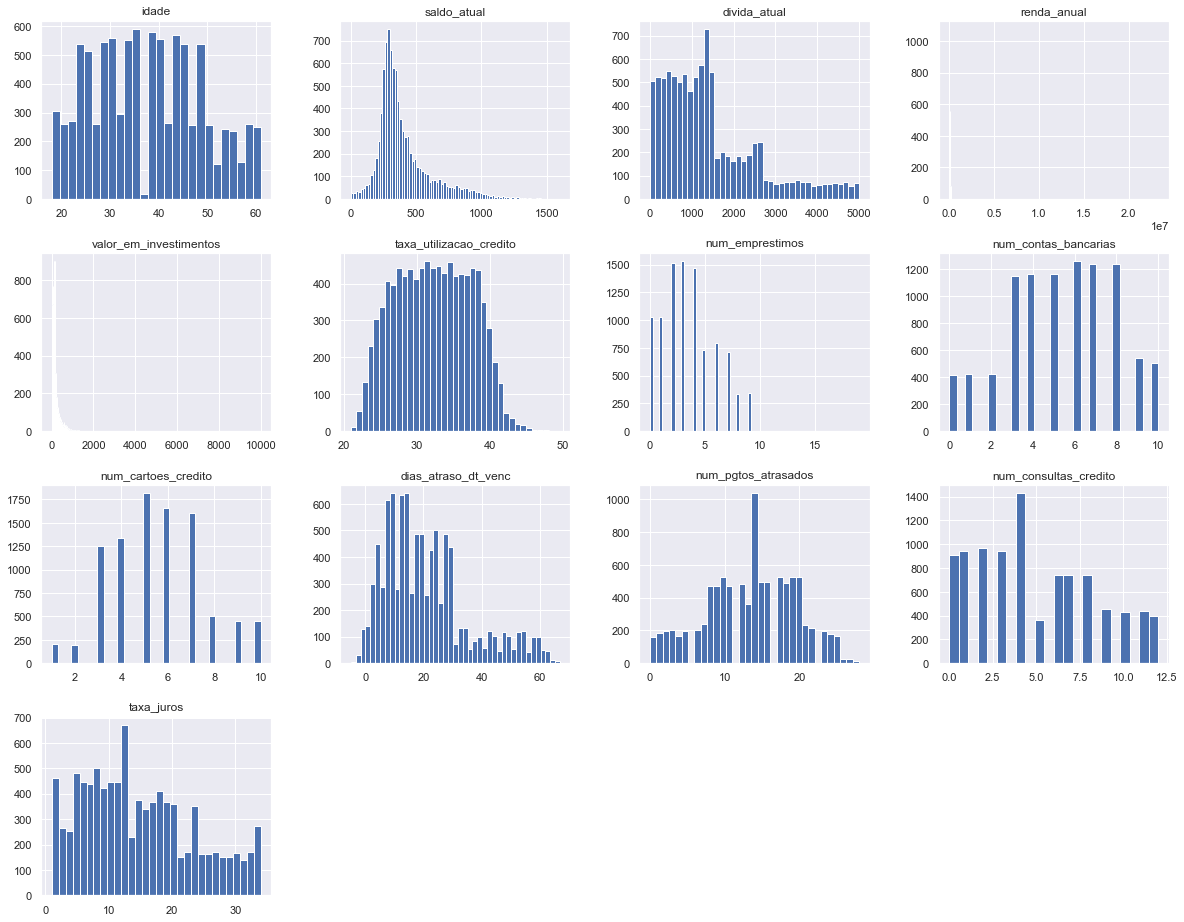

In [117]:
data_prep[numerical_features].hist(figsize=(18,15), bins='auto');


In [118]:
apply_log(data_prep)

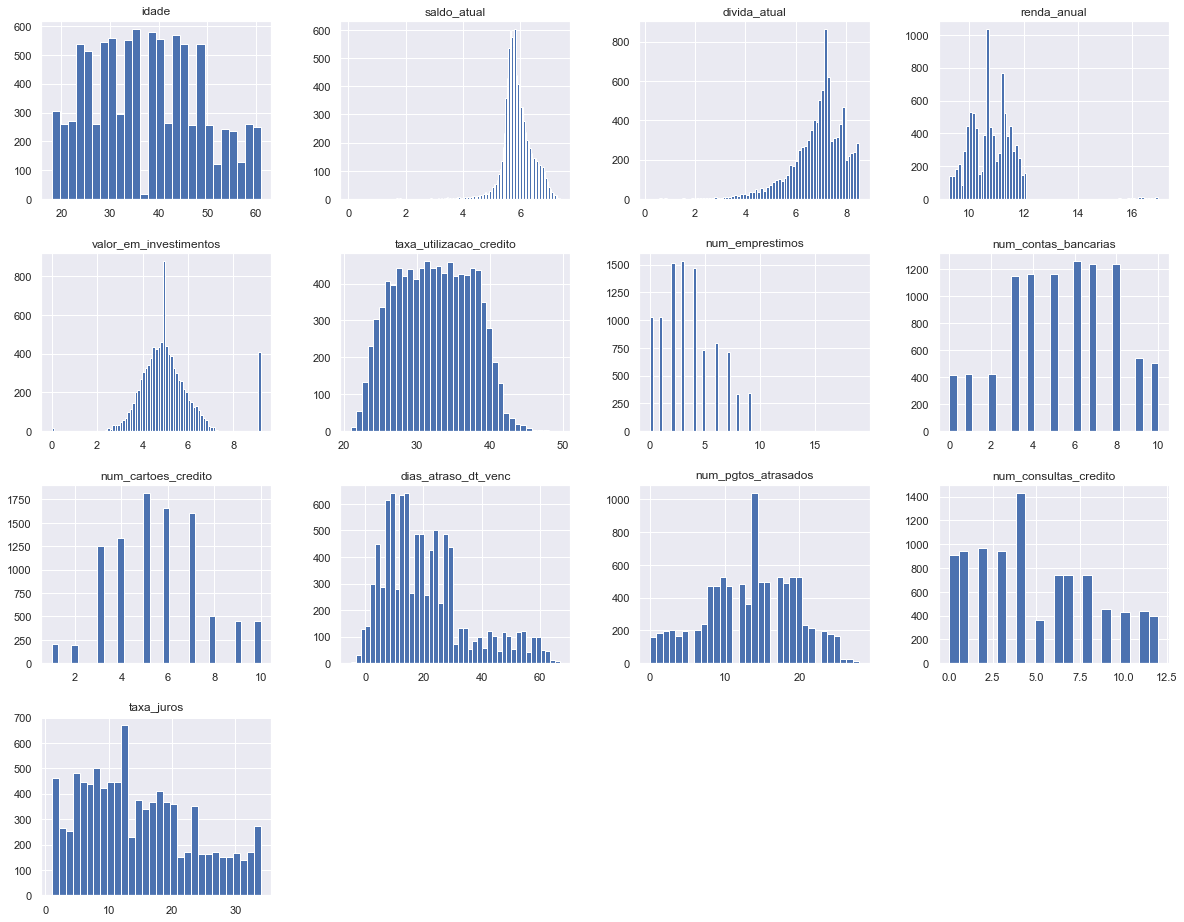

In [119]:
data_prep[numerical_features].hist(figsize=(18,15), bins='auto');

## 5.2 Encoding

In [120]:
#le_inv_ext = LabelEncoder()
#le_pes_pol = LabelEncoder()
# investe_exterior
#data_prep['investe_exterior'] = data_prep['investe_exterior'].apply(lambda x: 1 if x =='Sim' else 0)
#data_prep['investe_exterior'] = le_inv_ext.fit_transform(data_prep['investe_exterior'])
# pessoa_polit_exp
#data_prep['pessoa_polit_exp'] = data_prep['pessoa_polit_exp'].apply(lambda x: 1 if x =='Sim' else 0)
#data_prep['pessoa_polit_exp'] = le_pes_pol.fit_transform(data_prep['pessoa_polit_exp'])
# limite_adicional
#le = LabelEncoder()
#data_prep['limite_adicional'] = le.fit_transform(data_prep['limite_adicional'])
#data_prep['limite_adicional'] = data_prep['limite_adicional'].apply(lambda x: 0 if x =='Negar' else 1)
#lim_adi_dict = {'Negar':0, 'Conceder':1}
#data_prep = list(data_prep).map(lim_adi_dict)


data_prep['limite_adicional'] = data_prep['limite_adicional'].map({'Negar': 0, 'Conceder': 1})
data_prep['investe_exterior'] = data_prep['investe_exterior'].map({'Não': 0, 'Sim': 1})
data_prep['pessoa_polit_exp'] = data_prep['pessoa_polit_exp'].map({'Não': 0, 'Sim': 1})




In [121]:
data_prep.dtypes

id_cliente                   int64
idade                        int64
saldo_atual                float64
divida_atual               float64
renda_anual                float64
valor_em_investimentos     float64
taxa_utilizacao_credito    float64
num_emprestimos              int64
num_contas_bancarias         int64
num_cartoes_credito          int64
dias_atraso_dt_venc        float64
num_pgtos_atrasados          int64
num_consultas_credito        int64
taxa_juros                   int64
investe_exterior             int64
pessoa_polit_exp             int64
limite_adicional             int64
dtype: object

# 5.0 Feature Selection

In [122]:
df4 = data_prep.copy()

In [123]:
# data preparation
x_train_n = df4.drop( ['id_cliente', 'limite_adicional'], axis=1 )
y_train_n = df4['limite_adicional'].values

## 5.1 Random Forest

Feature ranking:
                   feature  importance
0               taxa_juros        0.13
0      num_cartoes_credito        0.13
0      dias_atraso_dt_venc        0.10
0      num_pgtos_atrasados        0.08
0             divida_atual        0.08
0     num_contas_bancarias        0.07
0    num_consultas_credito        0.07
0              renda_anual        0.06
0  taxa_utilizacao_credito        0.06
0              saldo_atual        0.06
0   valor_em_investimentos        0.06
0                    idade        0.05
0          num_emprestimos        0.03
0         investe_exterior        0.01
0         pessoa_polit_exp        0.00


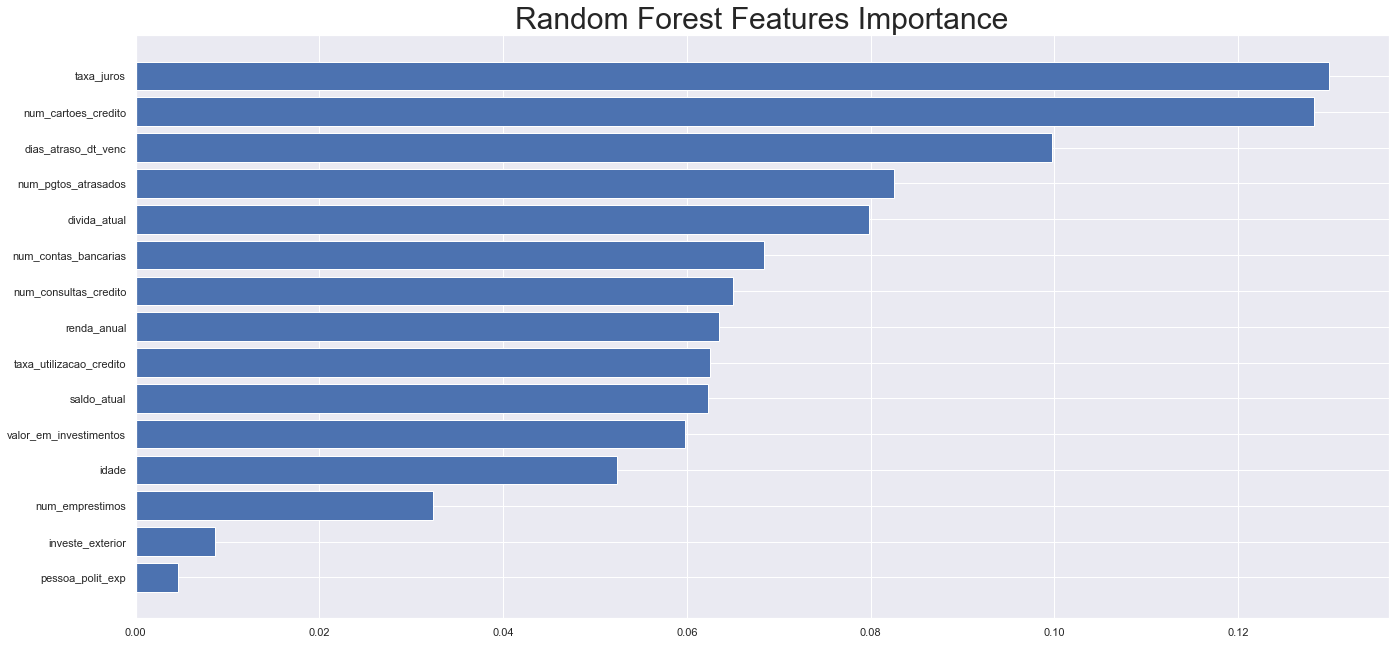

In [124]:
rf_selector = RandomForestClassifier(max_depth=100, n_jobs=-1)
rf_selector.fit(x_train_n, y_train_n)
rf_selector.feature_importances_

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, rf_selector.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

sorted_features = rf_selector.feature_importances_.argsort()

plt.barh(x_train_n.columns[sorted_features], rf_selector.feature_importances_[sorted_features])
plt.title('Random Forest Features Importance', fontsize=30);

## 5.2 XGBoost Classifier

Feature ranking:
                   feature  importance
0               taxa_juros        0.32
0      num_cartoes_credito        0.21
0    num_consultas_credito        0.10
0      dias_atraso_dt_venc        0.06
0      num_pgtos_atrasados        0.04
0     num_contas_bancarias        0.04
0   valor_em_investimentos        0.03
0  taxa_utilizacao_credito        0.03
0              saldo_atual        0.03
0             divida_atual        0.03
0          num_emprestimos        0.03
0                    idade        0.03
0              renda_anual        0.03
0         investe_exterior        0.03
0         pessoa_polit_exp        0.02


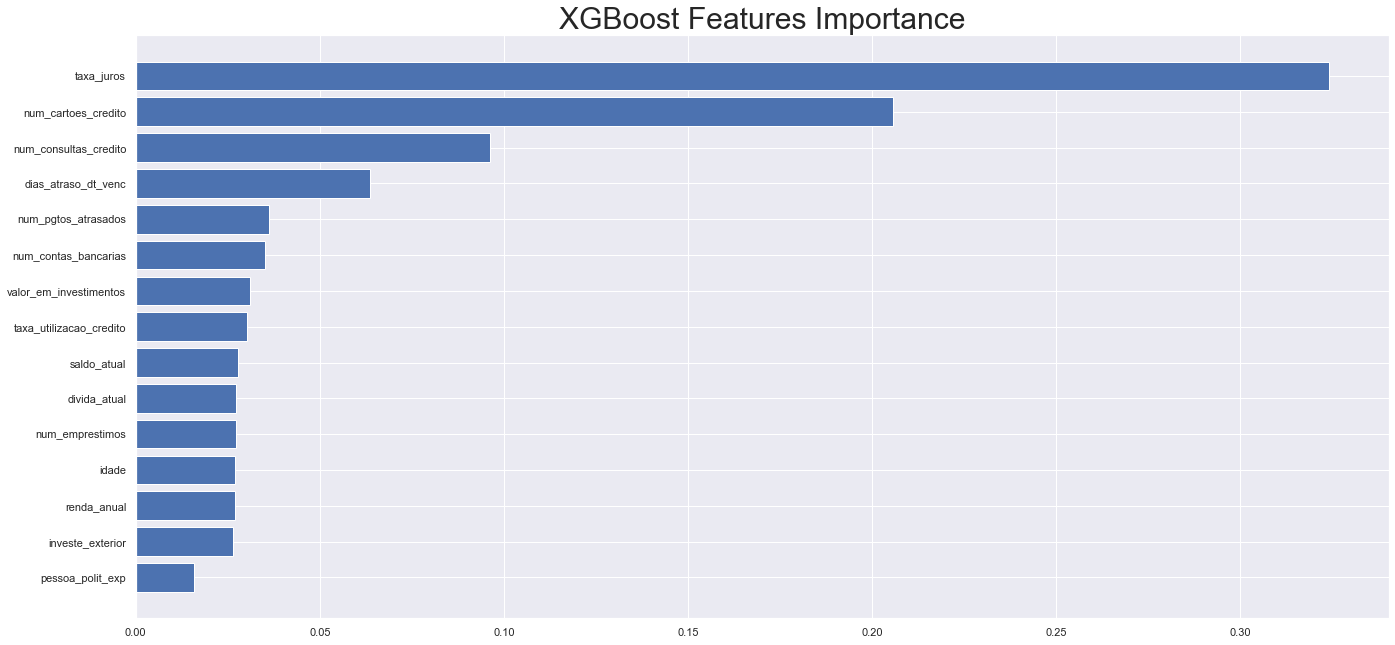

In [125]:
xgb_selector = XGBClassifier(random_state=42)
xgb_selector.fit(x_train_n, y_train_n)
xgb_selector.feature_importances_

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, xgb_selector.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

sorted_features = xgb_selector.feature_importances_.argsort()

plt.barh(x_train_n.columns[sorted_features], xgb_selector.feature_importances_[sorted_features])
plt.title('XGBoost Features Importance', fontsize=30);

## 5.1 Selected Features

In [126]:
target = 'limite_adicional' 

## Best Features XGB: taxa_juros, num_cartoes_credito, num_consultas_credito, dias_atraso_dt_venc, num_pgtos_atrasados, num_contas_bancarias
## Best Features RF: num_cartoes_credito, taxa_juros, dias_atraso_dt_venc, num_pgtos_atrasados, divida_atual, num_consultas_credito, num_contas_bancarias

selected_features = [#'saldo_atual', 
                    #'idade',
                    'divida_atual', 
                    #'renda_anual',
                    #'valor_em_investimentos', 
                    #'taxa_utilizacao_credito', 
                    #'num_emprestimos',
                    'num_contas_bancarias', 
                    'num_cartoes_credito', 
                    'dias_atraso_dt_venc',
                    'num_pgtos_atrasados', 
                    'num_consultas_credito', 
                    'taxa_juros',
                    #'investe_exterior',
                    #'pessoa_polit_exp', 
                    ]

X = df4[selected_features]
y = df4[target]

# 6.0 Machine Learning

## 6.1 Sampling

In [127]:
# Under Sampling
tl = TomekLinks()
X, y = tl.fit_resample(X,y)
counter = Counter(y)
np.bincount(y)

# Over Sampling
# smt=SMOTE()
# X, y = smt.fit_resample(X,y)
# np.bincount(y)

array([7622, 1505], dtype=int64)

In [128]:
# Dividir dataset entre Treino (80%) e Teste (20%) 
X_train, X_val, y_train, y_val = train_test_split(X[selected_features], y, stratify = y, test_size=0.20, random_state = 42)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((7301, 7), (7301,), (1826, 7), (1826,))

## 6.2 Random Forest

In [129]:
model_rf = RandomForestClassifier(random_state=seed)
model_rf.fit(X_train,y_train)
yhat_rf = model_rf.predict(X_val)
print(classification_report(y_val,yhat_rf ))
print(f"Random Forest - F1 Score : {round(f1_score(y_val, yhat_rf, average='weighted') ,5)}") #binary=default


              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1525
           1       0.72      0.61      0.66       301

    accuracy                           0.90      1826
   macro avg       0.82      0.78      0.80      1826
weighted avg       0.89      0.90      0.89      1826

Random Forest - F1 Score : 0.89258


### 6.2.1 Random Forest - Cross Validation



Confusion Matrix:


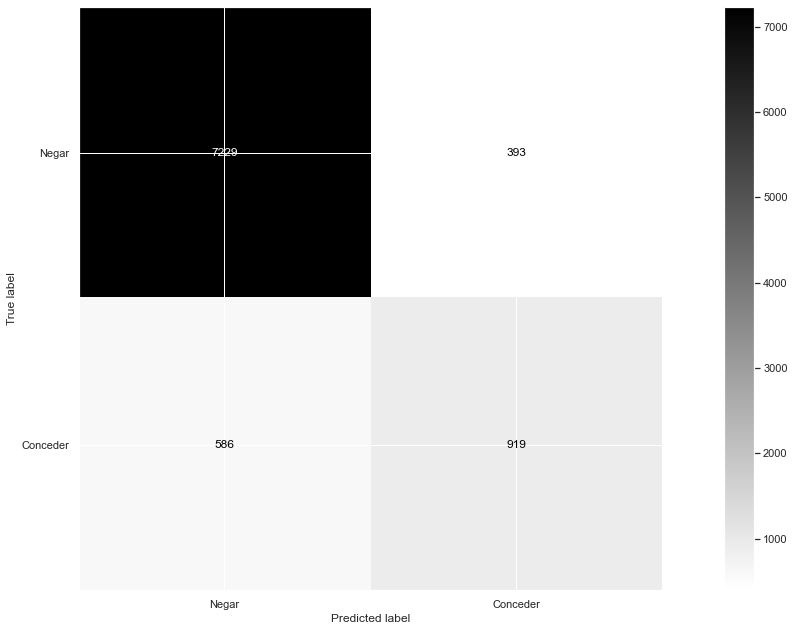

Metrics 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      7622
           1       0.70      0.61      0.65      1505

    accuracy                           0.89      9127
   macro avg       0.81      0.78      0.79      9127
weighted avg       0.89      0.89      0.89      9127



fit_time
[0.32496405 0.31934404 0.32921362 0.31275177] Mean: 0.3215683698654175 +/- 0.006177793237287452
score_time
[0.02600026 0.02499247 0.02600217 0.02599287] Mean: 0.025746941566467285 +/- 0.0004356105302232805
test_f1
[0.8923775  0.89640376 0.89486637 0.88905132] Mean: 0.8931747349822535 +/- 0.0027805744386848862


In [130]:
CVS(model_rf, X, y)

## 6.3 XGBoost 

In [131]:
model_xgboost = XGBClassifier(random_state=42)
model_xgboost.fit(X_train, y_train)
yhat_xgboost = model_xgboost.predict(X_val)
print(classification_report(y_val,yhat_xgboost ))
print(f"Random Forest - F1 Score : {round(f1_score(y_val, yhat_xgboost, average='weighted') ,5)}") #binary=default

              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1525
           1       0.66      0.62      0.64       301

    accuracy                           0.88      1826
   macro avg       0.79      0.78      0.79      1826
weighted avg       0.88      0.88      0.88      1826

Random Forest - F1 Score : 0.88339


### 6.3.1 XGBoost - Cross Validation



Confusion Matrix:


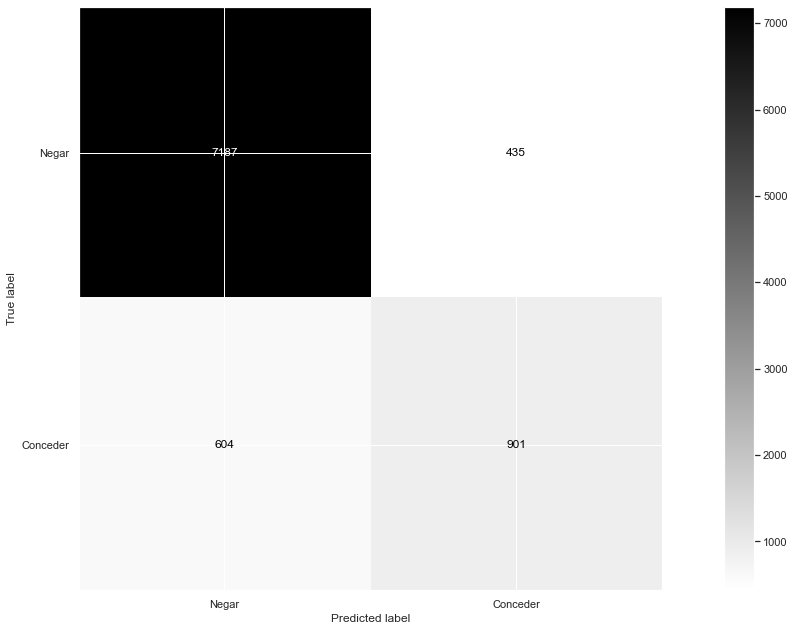

Metrics 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      7622
           1       0.67      0.60      0.63      1505

    accuracy                           0.89      9127
   macro avg       0.80      0.77      0.78      9127
weighted avg       0.88      0.89      0.88      9127



fit_time
[0.17666364 0.16593432 0.17669368 0.16526222] Mean: 0.1711384654045105 +/- 0.005545295911434768
score_time
[0.0036695  0.00429034 0.00460768 0.00337553] Mean: 0.003985762596130371 +/- 0.00048784020053493487
test_f1
[0.87823506 0.88549056 0.89025847 0.87766336] Mean: 0.8829118646432561 +/- 0.005245033744869785


In [132]:
CVS(model_xgboost, X, y)

## 6.4 LGBM

In [133]:
model_lgbm = lgbm.LGBMClassifier(n_estimators=200)
model_lgbm.fit(X_train, y_train)
yhat_lgbm = model_lgbm.predict(X_val)
print(classification_report(y_val,yhat_lgbm ))
print(f"Random Forest - F1 Score : {round(f1_score(y_val, yhat_lgbm, average='weighted') ,5)}") #binary=default

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1525
           1       0.69      0.62      0.65       301

    accuracy                           0.89      1826
   macro avg       0.81      0.78      0.79      1826
weighted avg       0.89      0.89      0.89      1826

Random Forest - F1 Score : 0.88894


### 6.4.1 LGBM - Cross Validation



Confusion Matrix:


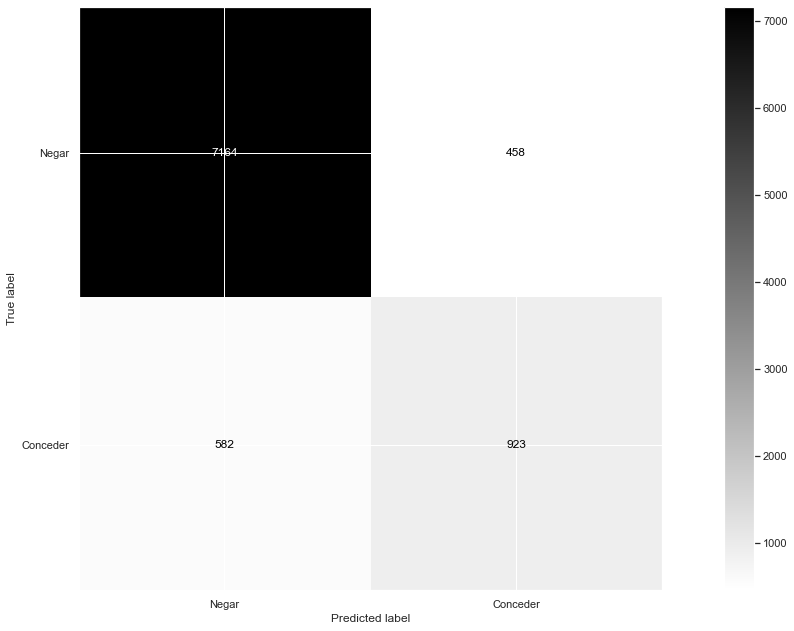

Metrics 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      7622
           1       0.67      0.61      0.64      1505

    accuracy                           0.89      9127
   macro avg       0.80      0.78      0.79      9127
weighted avg       0.88      0.89      0.88      9127



fit_time
[0.14419484 0.10688448 0.12199235 0.09829044] Mean: 0.11784052848815918 +/- 0.01742145417364463
score_time
[0.00446367 0.00338459 0.00545454 0.00473332] Mean: 0.004509031772613525 +/- 0.0007434244629026613
test_f1
[0.88694761 0.89049633 0.89166219 0.87742737] Mean: 0.8866333747175523 +/- 0.005591526370705963


In [134]:
CVS(model_lgbm, X, y)

# 6.0 Hyperparamters Tunning

## 6.1 Random Forest Tunning

Fitting 3 folds for each of 768 candidates, totalling 2304 fits


c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Confusion Matrix:


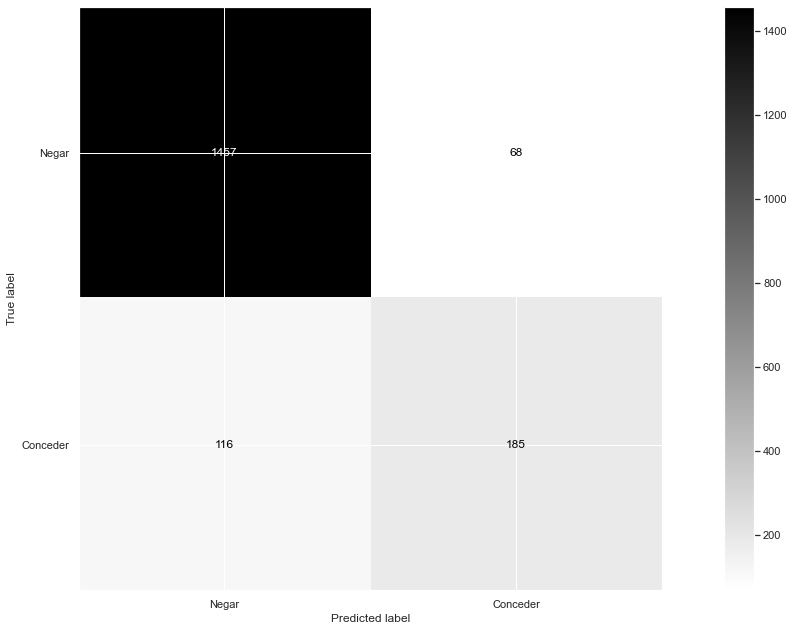

Metrics 
               precision    recall  f1-score   support

           0       0.93      0.96      0.94      1525
           1       0.73      0.61      0.67       301

    accuracy                           0.90      1826
   macro avg       0.83      0.79      0.80      1826
weighted avg       0.89      0.90      0.90      1826


F1 Best Score:0.8946830098407239

Best Paramters:
{'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 1000}

Best Estimator:
RandomForestClassifier(max_depth=9, max_features='auto', min_samples_split=7,
                       n_estimators=1000, random_state=7)


In [136]:
np.random.seed(7)

params  = {'criterion': ['entropy', 'gini'],
               'max_depth': [3,6,9,12],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 4, 6, 8],
               'min_samples_split': [5, 7,10],
               'n_estimators': [100,200,300,1000]}


rf = RandomForestClassifier(random_state=seed)
gs = GridSearchCV(estimator = rf, param_grid = params, cv = 3, scoring='f1_weighted', verbose= True, n_jobs = -1)
gs.fit(X_train,y_train)

rf_tuning_score = gs.best_score_
predict_rf_tunning = gs.best_estimator_.predict(X_val)

CM(y_val, predict_rf_tunning)

print(f"\nF1 Best Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}")

## 6.2 XGBoost Tunning

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
Confusion Matrix:


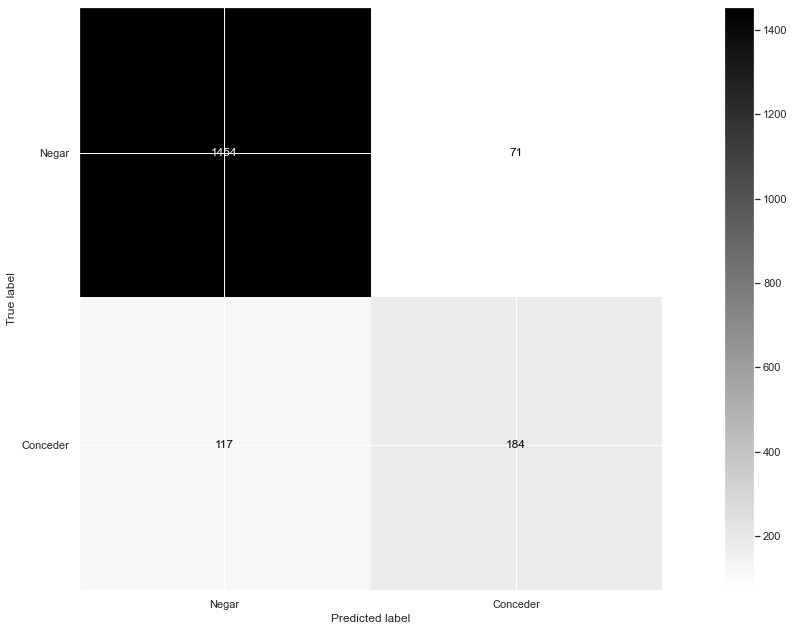

Metrics 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1525
           1       0.72      0.61      0.66       301

    accuracy                           0.90      1826
   macro avg       0.82      0.78      0.80      1826
weighted avg       0.89      0.90      0.89      1826


F1 Best Score:0.8918316255370543

Best Paramters:
{'colsample_bytree': 0.7, 'gamma': 0.3, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 100}

Best Estimator:
XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.3, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_lea

In [137]:
np.random.seed(7)

params = {
    "learning_rate":[0.05,0.15,0.30],
    "max_depth":[6,9,12,15], 
    "min_child_weight":[1,3,5,7],
    "gamma":[0.1,0.2,0.3],
    "colsample_bytree":[0.3, 0.4, 0.5, 0.7],
    'n_estimators':[100,200,300],
}

xgb = XGBClassifier()

gs = GridSearchCV(estimator = xgb, param_grid=params, scoring='f1_weighted', n_jobs=-1, cv=3, verbose=True)
gs.fit(X_train,y_train)

xgb_tunning_score = gs.best_score_
predict_xgb_tunning = gs.best_estimator_.predict(X_val)

CM(y_val, predict_xgb_tunning)

print(f"\nF1 Best Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}")

### 6.2.1 XGBoost Tunning - Using Hyperopt

In [90]:
from hyperopt import hp
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import fmin, tpe, STATUS_OK, STATUS_FAIL, Trials
from hyperopt.pyll import scope

# XGB parameters
xgb_reg_params = {
    'learning_rate': hp.loguniform('learning_rate', -7, 0),
    'max_depth': scope.int(hp.uniform('max_depth', 1, 100)),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.loguniform('gamma', -10, 10),
    'alpha': hp.loguniform('alpha', -10, 10),
    'lambda': hp.loguniform('lambda', -10, 10),
    'objective': 'binary:logistic',
    'seed': 123,
}
xgb_fit_params = {
    'eval_metric': 'auc',
    'early_stopping_rounds': 10,
    'verbose': False
}

xgb_para = dict()
xgb_para['reg_params'] = xgb_reg_params
xgb_para['fit_params'] = xgb_fit_params
xgb_para['loss_func' ] = lambda y, pred: np.sqrt(mean_squared_error(y, pred))

class HPOpt(object):

    def __init__(self, X_train, X_val, y_train, y_val):
        self.X_train = X_train
        self.X_val  = X_val
        self.y_train = y_train
        self.y_val  = y_val

    def process(self, fn_name, space, trials, algo, max_evals):
        fn = getattr(self, fn_name)
        try:
            result = fmin(fn=fn, space=space, algo=algo, max_evals=max_evals, trials=trials)
        except Exception as e:
            return {'status': STATUS_FAIL,
                    'exception': str(e)}
        return result, trials

    def xgb_reg(self, para):
        reg = xgb.XGBRegressor(**para['reg_params'])
        return self.train_reg(reg, para)

    def train_reg(self, reg, para):
        reg.fit(self.X_train, self.y_train,
                eval_set=[(self.X_train, self.y_train), (self.X_val, self.y_val)],
                **para['fit_params'])
        pred = reg.predict(self.X_val)
        loss = para['loss_func'](self.y_val, pred)
        return {'loss': loss, 'status': STATUS_OK}

obj = HPOpt(X_train, X_val, y_train, y_val)

xgb_opt = obj.process(fn_name='xgb_reg', space=xgb_para, trials=Trials(), algo=tpe.suggest, max_evals=100)

  2%|▏         | 2/100 [00:00<00:05, 18.63trial/s, best loss: 0.2722317004585142]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

  7%|▋         | 7/100 [00:00<00:06, 14.27trial/s, best loss: 0.27186402942888693]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

  9%|▉         | 9/100 [00:00<00:07, 12.90trial/s, best loss: 0.27186402942888693]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 14%|█▍        | 14/100 [00:01<00:08, 10.34trial/s, best loss: 0.27186402942888693]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 17%|█▋        | 17/100 [00:01<00:07, 11.14trial/s, best loss: 0.27186402942888693]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 19%|█▉        | 19/100 [00:01<00:08,  9.98trial/s, best loss: 0.27186402942888693]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 23%|██▎       | 23/100 [00:02<00:06, 11.80trial/s, best loss: 0.26366313834576965]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 25%|██▌       | 25/100 [00:02<00:08,  8.68trial/s, best loss: 0.26366313834576965]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 27%|██▋       | 27/100 [00:02<00:10,  6.74trial/s, best loss: 0.26159018491378266]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 31%|███       | 31/100 [00:03<00:08,  8.12trial/s, best loss: 0.26159018491378266]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 32%|███▏      | 32/100 [00:03<00:10,  6.24trial/s, best loss: 0.26087096790956704]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 35%|███▌      | 35/100 [00:04<00:11,  5.57trial/s, best loss: 0.26087096790956704]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 36%|███▌      | 36/100 [00:04<00:10,  6.06trial/s, best loss: 0.26087096790956704]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 38%|███▊      | 38/100 [00:04<00:10,  5.96trial/s, best loss: 0.2592991044448294] 

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 40%|████      | 40/100 [00:04<00:09,  6.40trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 41%|████      | 41/100 [00:05<00:09,  6.11trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 45%|████▌     | 45/100 [00:05<00:06,  8.03trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 49%|████▉     | 49/100 [00:06<00:06,  7.32trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 52%|█████▏    | 52/100 [00:06<00:05,  8.50trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 54%|█████▍    | 54/100 [00:06<00:04, 10.56trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 56%|█████▌    | 56/100 [00:06<00:04,  9.22trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 58%|█████▊    | 58/100 [00:07<00:04,  8.84trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 62%|██████▏   | 62/100 [00:07<00:03,  9.68trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 64%|██████▍   | 64/100 [00:07<00:04,  7.53trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 66%|██████▌   | 66/100 [00:08<00:04,  7.47trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 67%|██████▋   | 67/100 [00:08<00:04,  7.13trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 69%|██████▉   | 69/100 [00:08<00:04,  7.03trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 71%|███████   | 71/100 [00:09<00:04,  6.04trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 74%|███████▍  | 74/100 [00:09<00:04,  5.92trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 75%|███████▌  | 75/100 [00:09<00:04,  5.76trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 77%|███████▋  | 77/100 [00:10<00:04,  4.79trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 80%|████████  | 80/100 [00:10<00:03,  5.97trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 81%|████████  | 81/100 [00:10<00:03,  6.30trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



 84%|████████▍ | 84/100 [00:11<00:02,  6.59trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 86%|████████▌ | 86/100 [00:11<00:01,  7.51trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 89%|████████▉ | 89/100 [00:11<00:01,  8.19trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 91%|█████████ | 91/100 [00:12<00:01,  6.24trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 93%|█████████▎| 93/100 [00:12<00:01,  6.81trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 96%|█████████▌| 96/100 [00:13<00:00,  6.71trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

 98%|█████████▊| 98/100 [00:13<00:00,  7.54trial/s, best loss: 0.2592991044448294]

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constr

100%|██████████| 100/100 [00:13<00:00,  7.39trial/s, best loss: 0.2592991044448294]


c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(

c:\Users\Codo\anaconda3\envs\env1\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(



In [91]:
xgb_opt

({'alpha': 0.01747170892495493,
  'colsample_bytree': 0.7984529059274329,
  'gamma': 0.0022206605044105894,
  'lambda': 5.531909827970309,
  'learning_rate': 0.24947539024032217,
  'max_depth': 46.780750783489125,
  'min_child_weight': 0.3393997790077555,
  'subsample': 0.880816827777564},
 <hyperopt.base.Trials at 0x1b12ba6c850>)

## 6.3 LGBM Tunning

Fitting 3 folds for each of 1728 candidates, totalling 5184 fits
[LightGBM] [Warning] Unknown parameter: gamma
Confusion Matrix:


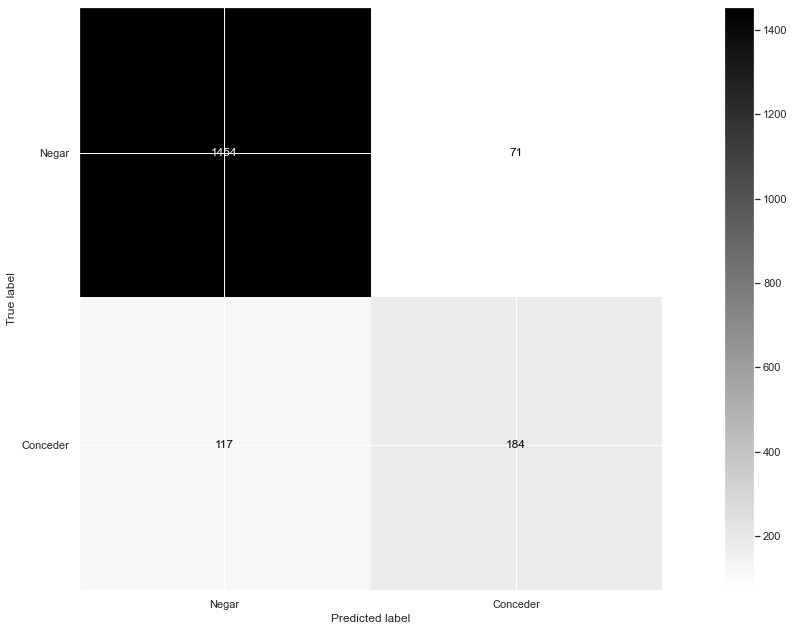

Metrics 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1525
           1       0.72      0.61      0.66       301

    accuracy                           0.90      1826
   macro avg       0.82      0.78      0.80      1826
weighted avg       0.89      0.90      0.89      1826


F1 Best Score:0.8913696604686011

Best Paramters:
{'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 100}

Best Estimator:
LGBMClassifier(colsample_bytree=0.4, gamma=0.1, learning_rate=0.05, max_depth=6,
               min_child_weight=1)


In [135]:
np.random.seed(7)

params = {
    "learning_rate":[0.05,0.15,0.30],
    "max_depth":[6,9,12,15], 
    "min_child_weight":[1,3,5,7],
    "gamma":[0.1,0.2,0.3],
    "colsample_bytree":[0.3, 0.4, 0.5, 0.7],
    'n_estimators':[100,200,300],
}

lgbm = lgbm.LGBMClassifier()

gs = GridSearchCV(estimator = lgbm, param_grid=params, scoring='f1_weighted', n_jobs=-1, cv=3, verbose=True)
gs.fit(X_train,y_train)

lgbm_tunning_score = gs.best_score_
predict_lgbm_tunning = gs.best_estimator_.predict(X_val)

CM(y_val, predict_xgb_tunning)

print(f"\nF1 Best Score:{gs.best_score_}") 
print(f"\nBest Paramters:\n{gs.best_params_}") 
print(f"\nBest Estimator:\n{gs.best_estimator_}")

# 7.0 Evaluating Best Model with tuned Parameters

## 7.1 Best parameters

In [154]:
rf_params ={'criterion': 'gini',
            'max_depth': 9,
            'min_samples_leaf': 1,
            'min_samples_split': 7,
            'n_estimators': 1000}

xgb_params = {'alpha': 0.02,
              'colsample_bytree': 0.80,
              'gamma': 0.01,
              'lambda': 5.53,
              'learning_rate': 0.25,
              'max_depth': 46,
              'min_child_weight': 0.34,
              'subsample': 0.88}

lgbm_params = {'colsample_bytree': 0.4, 
               'gamma': 0.1,
               'learning_rate': 0.05, 
               'max_depth': 6, 
               'min_child_weight': 1, 
               'n_estimators': 100}

## 7.2 Random Forest - best parameters



Confusion Matrix:


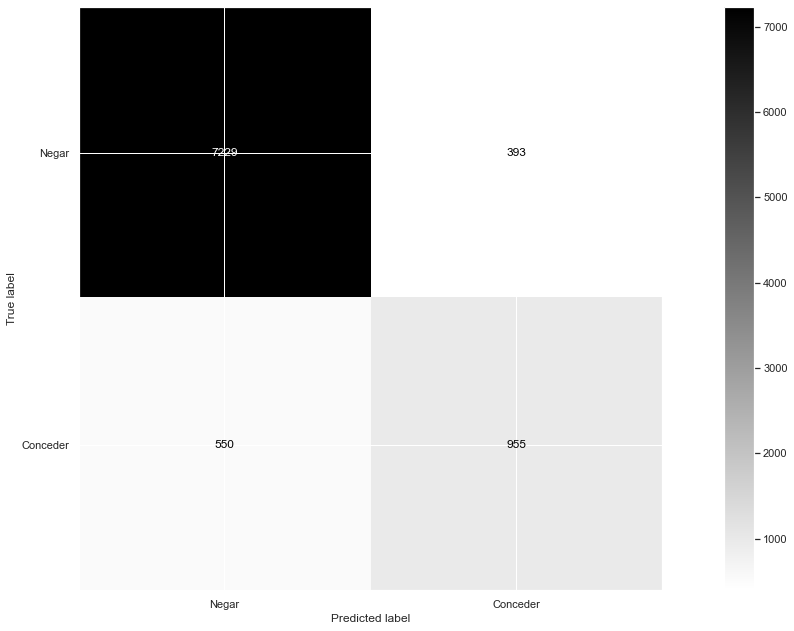

Metrics 
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      7622
           1       0.71      0.63      0.67      1505

    accuracy                           0.90      9127
   macro avg       0.82      0.79      0.80      9127
weighted avg       0.89      0.90      0.89      9127



fit_time
[2.50999355 2.49651432 2.43353343 2.5229125 ] Mean: 2.4907384514808655 +/- 0.03432092517269244
score_time
[0.18999791 0.17899728 0.18965721 0.17917848] Mean: 0.1844577193260193 +/- 0.005371574940107722
test_f1
[0.88982426 0.90239909 0.89858298 0.89173556] Mean: 0.8956354718865294 +/- 0.005084629433930906


In [155]:
rf_tuned = RandomForestClassifier(**rf_params)
y_pred_rf_tuned = CVS(rf_tuned,X,y)

## 7.3 XGBoost - best parameters



Confusion Matrix:


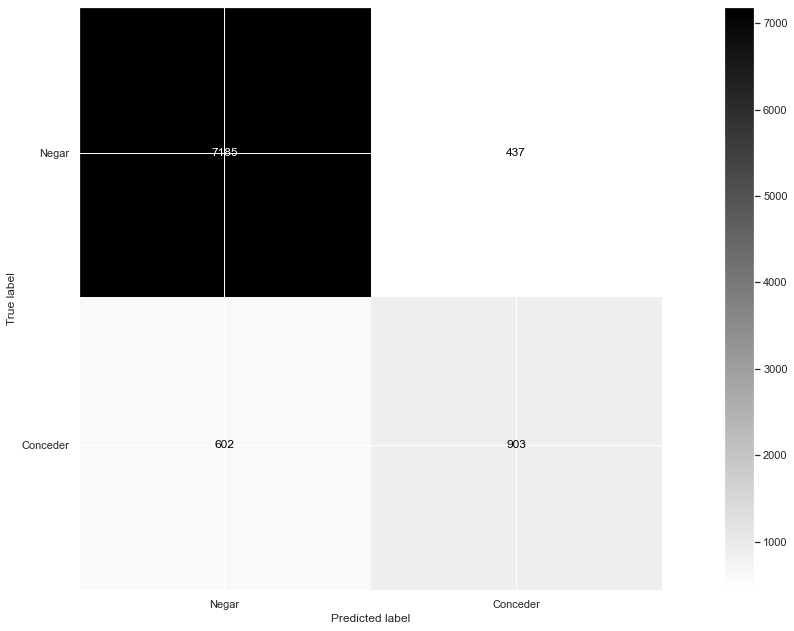

Metrics 
               precision    recall  f1-score   support

           0       0.92      0.94      0.93      7622
           1       0.67      0.60      0.63      1505

    accuracy                           0.89      9127
   macro avg       0.80      0.77      0.78      9127
weighted avg       0.88      0.89      0.88      9127



fit_time
[0.35446    0.33633995 0.33349633 0.32756019] Mean: 0.33796411752700806 +/- 0.010036869267979483
score_time
[0.00561547 0.00516129 0.0053966  0.00499058] Mean: 0.005290985107421875 +/- 0.00023638652053527523
test_f1
[0.8828322  0.8913939  0.89703431 0.87868677] Mean: 0.8874867959099948 +/- 0.007168093805750164


In [156]:
xgb_tuned = XGBClassifier(**xgb_params)
y_pred_xgb_tuned = CVS(xgb_tuned,X,y)

## 7.4 LGBM - best parameters



Confusion Matrix:


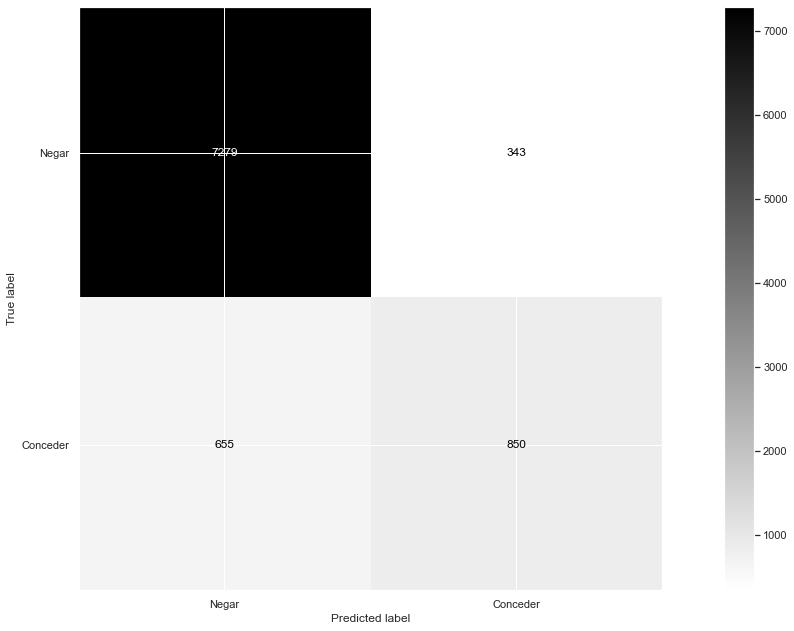

Metrics 
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      7622
           1       0.71      0.56      0.63      1505

    accuracy                           0.89      9127
   macro avg       0.81      0.76      0.78      9127
weighted avg       0.88      0.89      0.89      9127



fit_time
[0.10346746 0.10014105 0.1019032  0.10991979] Mean: 0.10385787487030029 +/- 0.0036923821707333417
score_time
[0.00394416 0.00405145 0.00354862 0.00449085] Mean: 0.004008769989013672 +/- 0.00033546065974291654
test_f1
[0.88339382 0.89417214 0.89169563 0.8785622 ] Mean: 0.8869559455312248 +/- 0.006278571728528263


In [157]:
lgbm_tuned = XGBClassifier(**lgbm_params)
y_pred_lgbm_tuned = CVS(lgbm_tuned,X,y)

## Evaluating Results on Test

In [216]:
data_test = data_test_raw.copy()

#### KNN Imputation - Test

In [217]:
nan_transformer(data_test)

data_test.isna().sum()

id_cliente                   0
idade                       96
saldo_atual                  0
divida_atual                 0
renda_anual                  0
valor_em_investimentos       0
taxa_utilizacao_credito      0
num_emprestimos            155
num_contas_bancarias        37
num_cartoes_credito         69
dias_atraso_dt_venc          0
num_pgtos_atrasados         24
num_consultas_credito       37
taxa_juros                  64
investe_exterior             0
pessoa_polit_exp             0
dtype: int64

In [218]:
X_knn = data_test.drop(['id_cliente'], axis=1)

numerical_features = X_knn.select_dtypes(include = ['int64','float64']).columns.values
categorical_features = X_knn.select_dtypes(include = ['object']).columns.values

num_impute = KNNImputer()

num_impute.fit(X_knn[numerical_features])
X_knn[numerical_features] = num_impute.transform(X_knn[numerical_features])

In [219]:
data_test = pd.concat([data_test[['id_cliente']], X_knn],axis=1)

#### Normalize - Test

In [220]:
apply_log(data_test)

#### Encoding - Test

In [221]:
data_test['investe_exterior'] = data_test['investe_exterior'].map({'Não': 0, 'Sim': 1})
data_test['pessoa_polit_exp'] = data_test['pessoa_polit_exp'].map({'Não': 0, 'Sim': 1})

In [222]:
data_test.isna().sum()

id_cliente                 0
idade                      0
saldo_atual                0
divida_atual               0
renda_anual                0
valor_em_investimentos     0
taxa_utilizacao_credito    0
num_emprestimos            0
num_contas_bancarias       0
num_cartoes_credito        0
dias_atraso_dt_venc        0
num_pgtos_atrasados        0
num_consultas_credito      0
taxa_juros                 0
investe_exterior           0
pessoa_polit_exp           0
dtype: int64

### Using Best Model

In [223]:
#y = data_prep[target]
X_test = data_test[selected_features]
X_test.shape, X.shape

((3000, 7), (9127, 7))

In [224]:
rf_tuned.fit(X, y)
ypred_rf_tuned=rf_tuned.predict(X_test)
ypred_rf_tuned

array([1, 0, 0, ..., 0, 1, 1], dtype=int64)

In [225]:
data_test['limite_adicional'] = ypred_rf_tuned

data_test['limite_adicional'] = data_test['limite_adicional'].apply(lambda x: 'Negar' if x == 0 else 'Conceder')

In [226]:
data_test['limite_adicional'].value_counts(normalize=True)

Negar      0.83
Conceder   0.17
Name: limite_adicional, dtype: float64

In [212]:
data_test[['id_cliente','limite_adicional']].to_csv("submission.csv", index=False)